<a href="https://colab.research.google.com/github/dharmesh-data/Capstone_NYC_Taxi_TRip/blob/main/Dc_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/Supervised ML Regression/NYC taxi trip time prediction/Copy of NYC Taxi Data.csv")

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Checking the shape so we get an idea of how many rows and features we have


In [ ]:
df.shape

(1458644, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


We have id, pickup_datetime, dropoff_datetime, and store_and_fwd_flag of the type ‘object’. vendor_id, passenger_count, and trip_duration are of type int. pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude are of type float.bold text

Some observations about the columns are :
* **pickup_datetime** and **pickup_datetime** are in string format that are to be converted into datetime format.
* **store_and_fwd_flag** is a categorical variable.

In [ ]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


So from here we can see that:
* Pasenger count varies from 0 to 9.
* Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them.

After the basic analysis of our data we can see we have some outliers. Now let's chek if there isany null data.

In [ ]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

1. We see that id has 1458644 unique values which are equal to the number of rows in our dataset.
2. There are 2 unique vendor ids.
3. There are 9 unique passenger counts.
4. There are 2 unique values for store_and_fwd_flag, that we also saw in the description of the variables, which are Y and N.

###**Feature Selection**
1. Day hour
2. distance
3. Weekday
4. Month
5. morning, evening 
6. passenger count ( less impact)
7. pickup and dropoff location
8. speed

Remember pickup_datetime and dropoff_datetime were both of type object.we'll convert it to datetime object so that we get some information out of it.

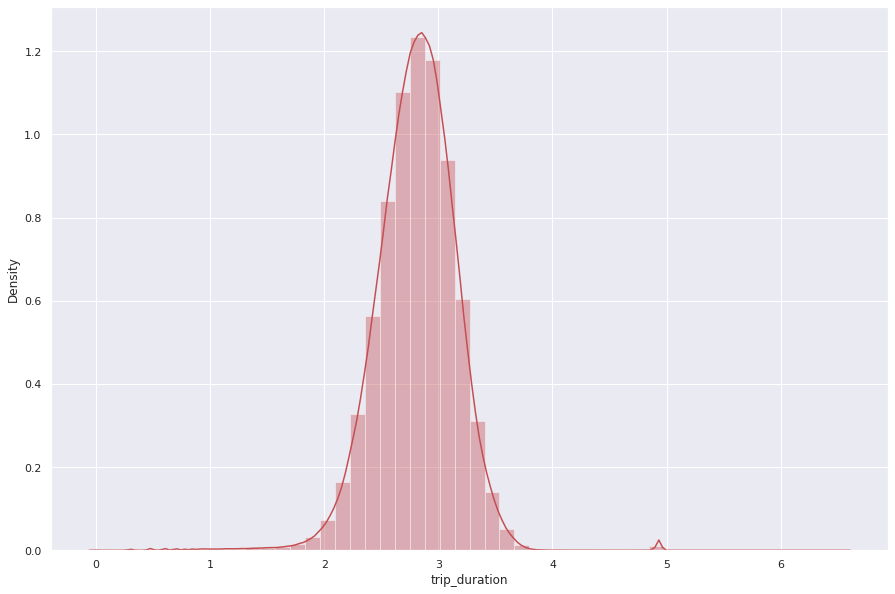

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(df['trip_duration']),color="R")

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

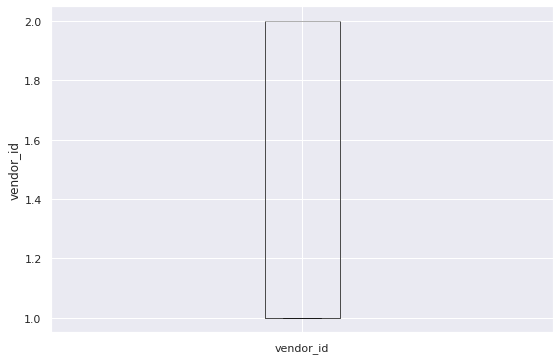

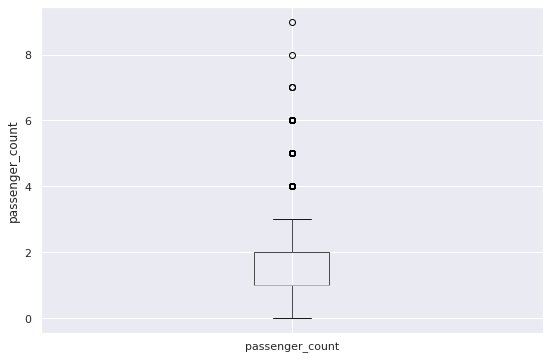

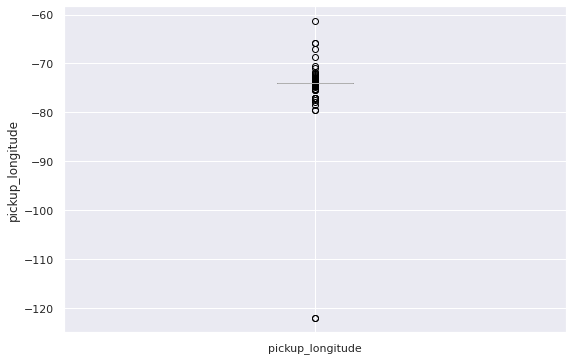

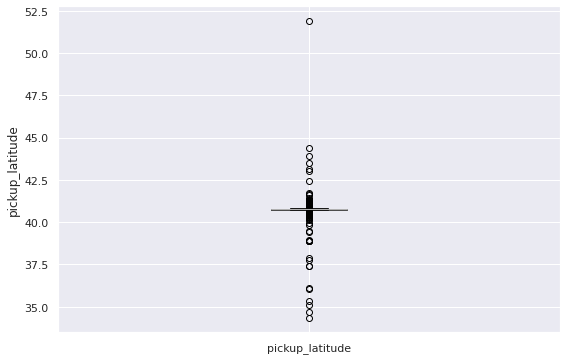

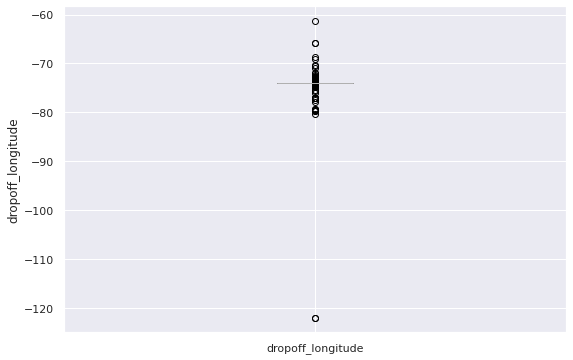

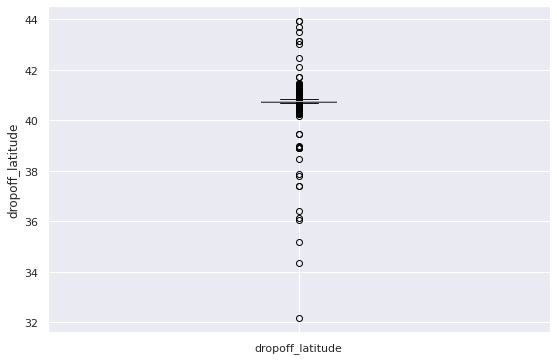

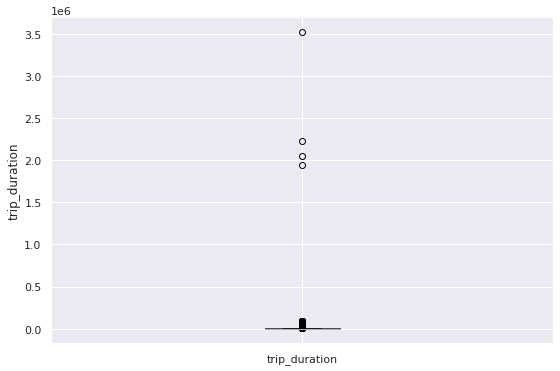

In [ ]:
# plot a boxplot for the label by each numerical feature  
for col in df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Okay so what we know now :
* Vendor ID has no outlier.
* In passenger count 4 and more passengers are being treated as outliers.
* pickup_longitude and pickup_latitude has outliers as well.
* dropoff_longitude and dropoff_latitude has outliers too.
* Our target variable trip_duration has alot of outliers 




In [ ]:
#Converting datetime format to fetch the other details
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_date_month'] = df['pickup_datetime'].dt.month
df['pickup_date'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['dropoff_datetime'].dt.hour
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_date_month,pickup_date,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,19,12
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,6,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,26,13


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_day          1458644 non-null  object        
 12  dropoff_day         1458644 non-null  object        
 13  pickup_date_

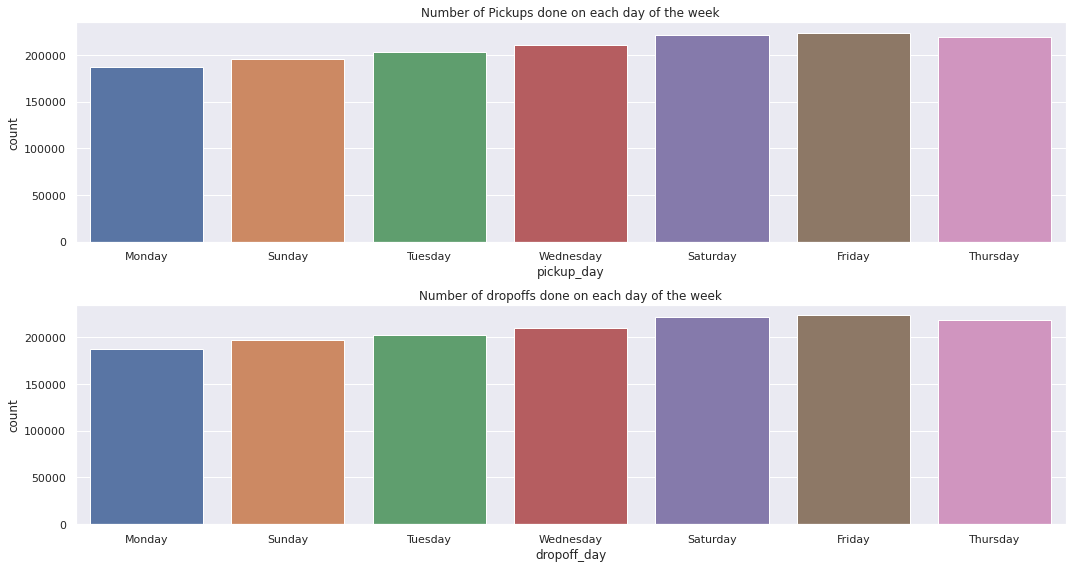

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

**Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.**

Well it actually makes sense because most people will want to go out and enjoy their weekends partying and noone will have time to do that on a Monday. As everyone needs to earn the money back which was spent on Friday while parying.

Okay so as we have our days now let's also try to figure out the time and see what time was the busiest and what is least busiest. 

**The distribution of Pickup and Drop Off hours of the day**


The time part is represented by hours,minutes and seconds which is difficult for the analysis thus we divide the times into 4 time zones: 
* **Morning** (4 hrs to 10 hrs) 
* **Midday** (10 hrs to 16 hrs)
* **Evening** (16 hrs to 22 hrs) 
* **Late night** (22 hrs to 4 hrs)

In [ ]:
bins=np.array([0,1800,3600,5400,7200,90000])
df['duration_time']=pd.cut(df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [ ]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

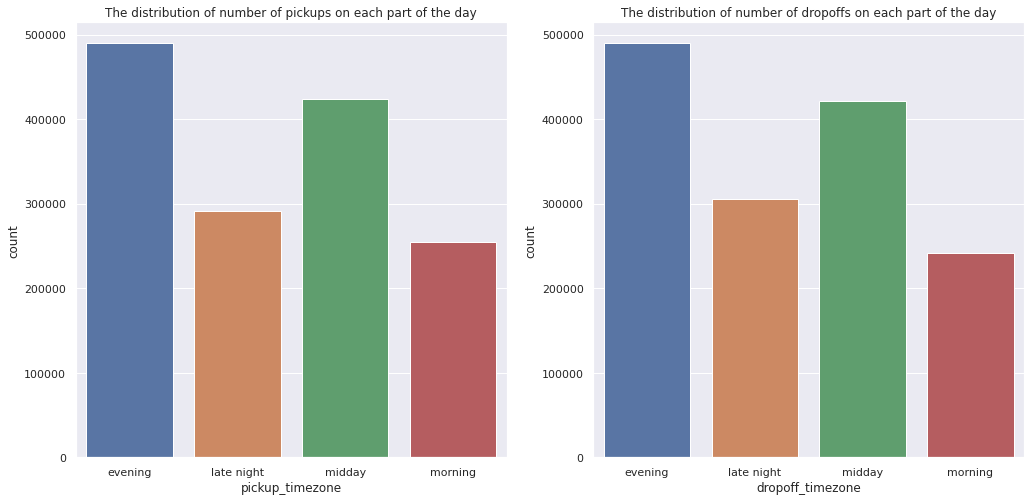

In [ ]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(17,8))
sns.countplot(x='pickup_timezone',data=df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

So now we can see that our taxi's were booked in the evening most and midday following it while very less people travel in the morning as compared.


Text(0.5, 1.0, 'The Distribution of percentage of different duration of trips')

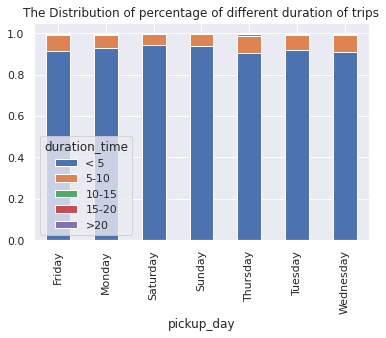

In [ ]:
ax1=df.groupby('pickup_day')['duration_time'].value_counts(normalize=True).unstack()
ax1.plot(kind='bar', stacked='True')
plt.title('The Distribution of percentage of different duration of trips')

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [ ]:
df["distance"] = df.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)

removing outlier


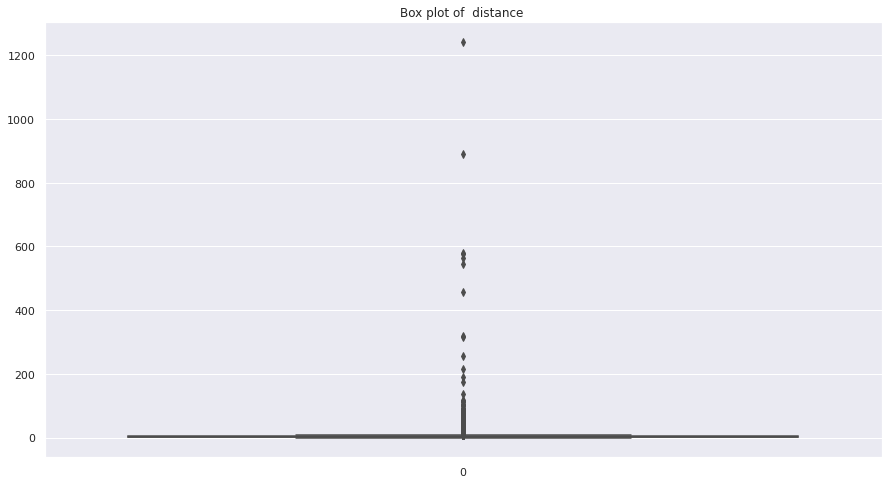

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=df['distance'], orient="v")

In [ ]:
percentile_q1 = np.percentile(df['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(df['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(df['distance'],75)
print(percentile_q3)

1.23222326737417
2.0943743977620386
3.8765539736919856


In [ ]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

In [ ]:
print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.734272792102554
Upper limit for outlier  : 7.843050033168709


In [ ]:
df=df[df['distance']>lower_limit_outlier]
df=df[df['distance']<upper_limit_outlier]

In [ ]:
df.shape

(1317971, 20)

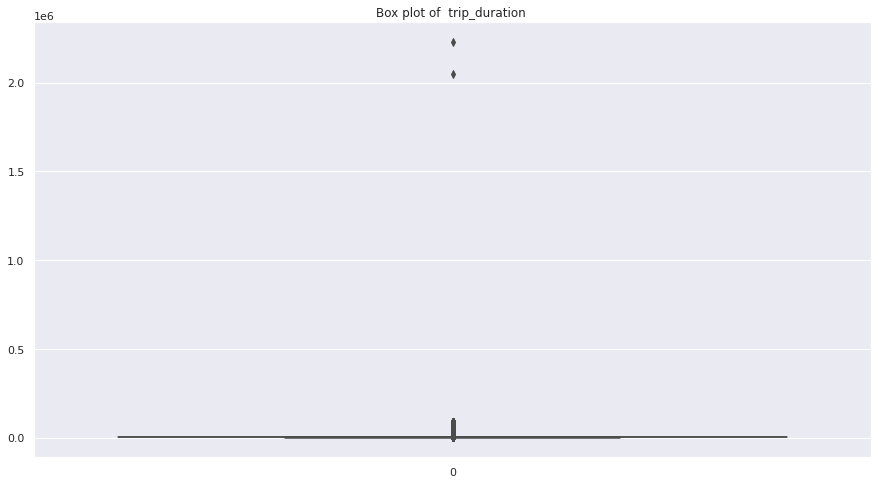

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=df['trip_duration'], orient="v")

In [ ]:
percentile_q1_trip_duration = np.percentile(df['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(df['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(df['trip_duration'],75)
print(percentile_q3_trip_duration)

373.0
605.0
931.0


In [ ]:
iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

In [ ]:
print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [ ]:
df=df[df['trip_duration']>0]
df=df[df['trip_duration']<upper_limit_outlier_trip_duration]

In [ ]:
df.shape

(1277396, 20)

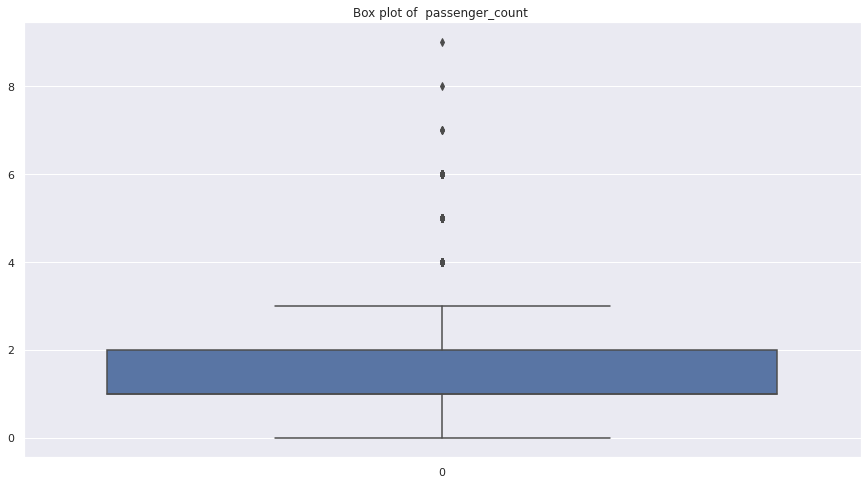

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=df['passenger_count'], orient="v")

In [ ]:
percentile_q1_passenger_count = np.percentile(df['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(df['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(df['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [ ]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr

In [ ]:
print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [ ]:
df=df[df['passenger_count']>0]
df=df[df['passenger_count']<upper_limit_outlier_passenger_count]

In [ ]:
df.shape

(1142603, 20)

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_date_month,pickup_date,pickup_hour,duration_time,pickup_timezone,dropoff_timezone,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,14,17,< 5,evening,evening,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,12,0,< 5,late night,late night,1.806074
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,6,19,< 5,evening,evening,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,26,13,< 5,midday,midday,1.188962
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,Saturday,Saturday,5,21,8,< 5,morning,morning,5.716775


In [ ]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [ ]:
df['Day']=df['pickup_datetime'].dt.day_name()

In [ ]:
df["year"] = df["pickup_datetime"].apply(lambda x: x.year)
df["month"] = df["pickup_datetime"].apply(lambda x: x.month)
df["day_num"] = df["pickup_datetime"].apply(lambda x: x.day)
df["hour"] = df["pickup_datetime"].apply(lambda x: x.hour)
df["minute"] = df["pickup_datetime"].apply(lambda x: x.minute)

* Converting trip duration into hours.
* Taking log of our distance for normalisation of data.
* Taking log of our trip duration as well to normalize it's data

In [ ]:
df['trip_duration_hour']=df['trip_duration']/3600
df['log_distance']=np.log(df.distance)
df['log_trip_duration']=np.log(df.trip_duration_hour)

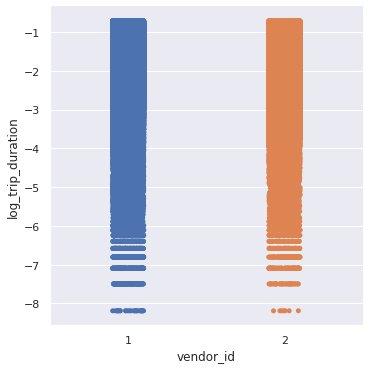

In [ ]:
sns.catplot(x="vendor_id", y="log_trip_duration",kind="strip",data=df)

***Here we see that vendor 1 mostly provides short trip duration cabs while vendor 2 provides cab for both short and long trips***

###Univariate Analysis

The univariate analysis involves studying patterns of all variables individually.

**Target Variable**

Let us start by analyzing the target variable.

TRip duration

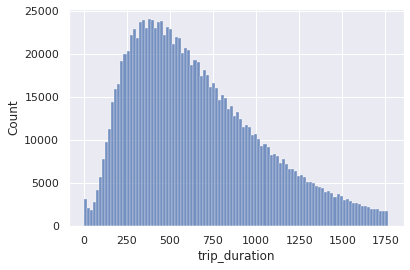

In [ ]:
sns.histplot(df['trip_duration'],kde=False,bins=100)

The histogram is right skewed. let's look at the box plot

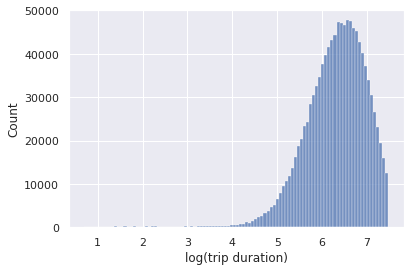

In [ ]:
sns.histplot(np.log(df['trip_duration']+1),kde=False,bins=100)
plt.xlabel('log(trip duration)')
plt.show()

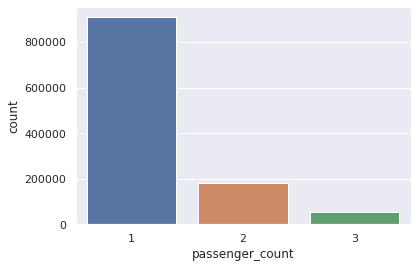

In [ ]:
sns.countplot(x='passenger_count',data=df)

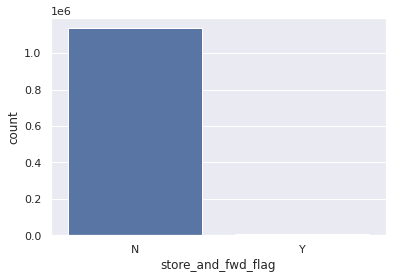

In [ ]:
sns.countplot(x='store_and_fwd_flag',data=df)

## Trips per day

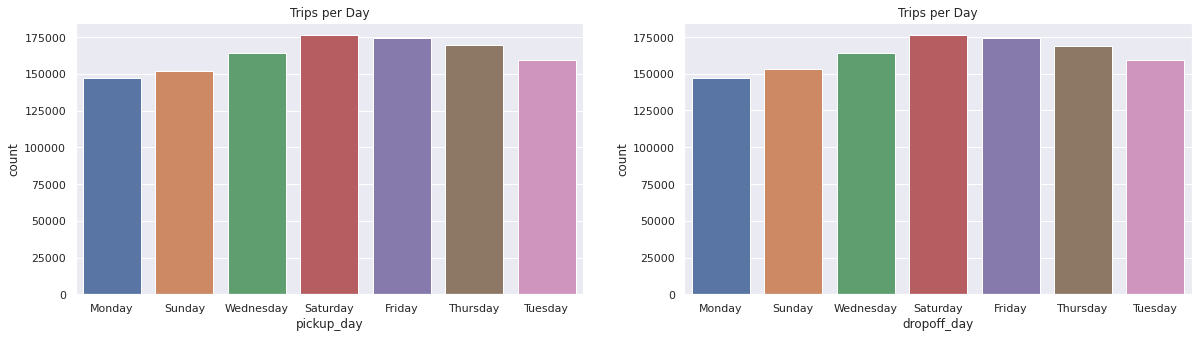

In [ ]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Trips per Day')
ax1=sns.countplot(x="pickup_day",data=df,ax=ax1)
ax2.set_title('Trips per Day')
ax2=sns.countplot(x="dropoff_day",data=df,ax=ax2)

here we can see that the fridays are the busiest day followes by saturday because of weekend

##Bivariate Analysis
Bivariate Analysis involves finding relationships, patterns, and correlations between two variables.

Text(0.5, 1.0, 'Trip Duration per Vendor')

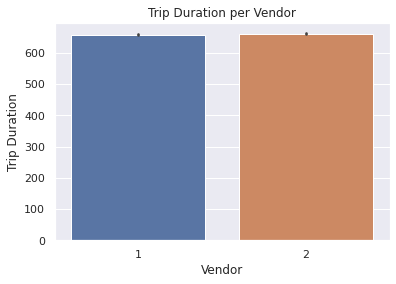

In [ ]:
#trips duration per vendor
sns.barplot(y='trip_duration',x='vendor_id',data=df,estimator=np.mean)
plt.ylabel("Trip Duration")
plt.xlabel("Vendor")
plt.title("Trip Duration per Vendor")

vendor id 2 takes longer trips as compare to vendor 1

<Figure size 576x360 with 0 Axes>

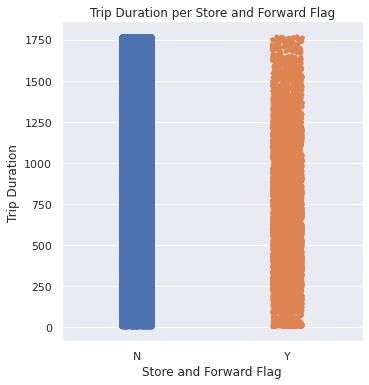

In [ ]:
plt.figure(figsize=(8,5))
sns.catplot(y='trip_duration',x='store_and_fwd_flag',data=df,kind='strip')
plt.title("Trip Duration per Store and Forward Flag")
plt.ylabel("Trip Duration")
plt.xlabel("Store and Forward Flag")
plt.show()

Trip duration is generally longer for trips whose flag was not stored.

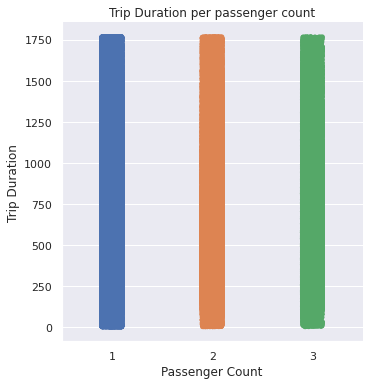

<Figure size 1080x720 with 0 Axes>

In [ ]:
sns.catplot(y='trip_duration',x='passenger_count',data=df,kind='strip')
plt.xlabel('Passenger Count')
plt.ylabel('Trip Duration')
plt.title("Trip Duration per passenger count")
plt.figure(figsize=(15,10))
plt.show()

There is no visible relation between trip duration and passenger count

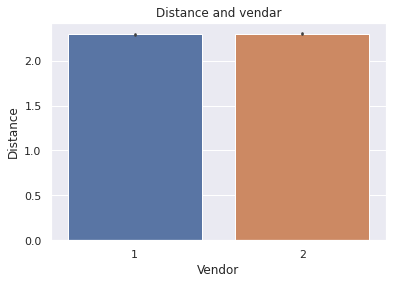

In [ ]:
figure,ax=plt.subplots(ncols=1)
ax=sns.barplot(x='vendor_id',y='distance',data=df,estimator=np.mean)
plt.xlabel('Vendor')
plt.ylabel('Distance')
plt.title("Distance and vendar")
plt.show()

In [ ]:
# One hot encoding
df= pd.get_dummies(df, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,dropoff_day,pickup_date_month,pickup_date,pickup_hour,duration_time,pickup_timezone,dropoff_timezone,distance,year,month,day_num,hour,minute,trip_duration_hour,log_distance,log_trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,Monday,Monday,3,14,17,< 5,evening,evening,1.498991,2016,3,14,17,24,0.126389,0.404792,-2.068392,1,0,0,1,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,Sunday,Sunday,6,12,0,< 5,late night,late night,1.806074,2016,6,12,0,43,0.184167,0.591155,-1.691914,1,0,0,0,0,1,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,Wednesday,Wednesday,4,6,19,< 5,evening,evening,1.485965,2016,4,6,19,32,0.119167,0.396064,-2.127232,1,0,0,0,0,0,0,0,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,Saturday,Saturday,3,26,13,< 5,midday,midday,1.188962,2016,3,26,13,30,0.120833,0.173080,-2.113343,1,0,0,0,1,0,0,0,0
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,1551,Saturday,Saturday,5,21,8,< 5,morning,morning,5.716775,2016,5,21,7,54,0.430833,1.743405,-0.842034,1,0,0,0,1,0,0,0,0


In [ ]:
features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [ ]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_df=df[newdata]

In [ ]:
from scipy.stats import zscore
#Train test split

X = df[features].apply(zscore)[:100000]
y=df['trip_duration_hour'][:100000]

In [ ]:
X[:5]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,month,hour,minute,store_and_fwd_flag_N,store_and_fwd_flag_Y,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1.026271,-0.473673,-0.037635,0.555490,0.183839,0.423383,-0.506316,-0.297550,0.526369,-0.325740,0.072735,-0.072735,-0.424734,2.601163,-0.426811,-0.391904,-0.417209,-0.402327,-0.409479
1,-0.974402,-0.473673,-0.012904,-0.532267,-0.308596,-0.753048,-0.311464,1.488312,-2.138774,0.771428,0.072735,-0.072735,-0.424734,-0.384443,-0.426811,2.551646,-0.417209,-0.402327,-0.409479
3,1.026271,-0.473673,-0.434078,-1.220803,-0.489271,-1.587400,-0.514582,0.297738,0.839915,0.136226,0.072735,-0.072735,-0.424734,-0.384443,-0.426811,-0.391904,-0.417209,-0.402327,2.442129
4,1.026271,-0.473673,0.091765,1.491385,0.066659,1.001112,-0.703038,-0.297550,-0.100724,0.020734,0.072735,-0.072735,-0.424734,-0.384443,2.342956,-0.391904,-0.417209,-0.402327,-0.409479
7,1.026271,-0.473673,0.145456,1.660623,0.779548,0.251171,2.169980,0.893025,-1.041363,1.406631,0.072735,-0.072735,-0.424734,-0.384443,2.342956,-0.391904,-0.417209,-0.402327,-0.409479


###linearregressor

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#model building
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)


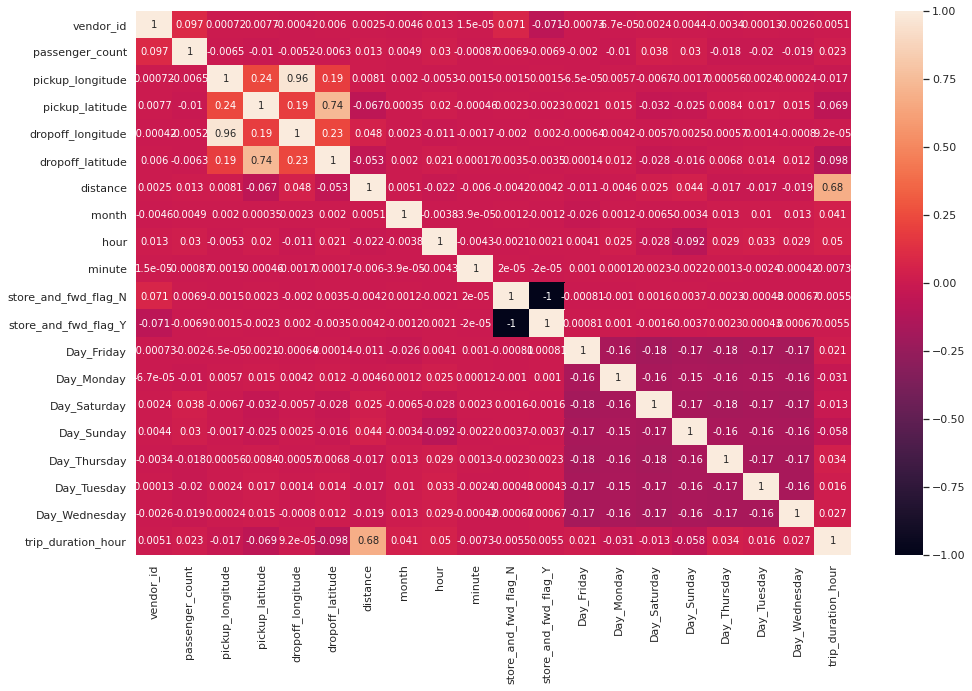

In [ ]:
plt.figure (figsize= (16,10))
sns.heatmap(trip_df.corr(), annot=True)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)


In [ ]:
reg.score(X_train, y_train)

0.49760282113255905

In [ ]:
y_pred_train = reg.predict(X_train)

In [ ]:
y_pred_train

array([0.17743374, 0.25381924, 0.21848751, ..., 0.10083844, 0.13448788,
       0.15746762])

In [ ]:
y_pred_test = reg.predict(X_test)

In [ ]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.005546665930139359
RMSE : 0.07447594195536811
R2 : 0.49760282113255905
Adjusted R2 :  0.4974834719652863


In [ ]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.005474782168878371
RMSE : 0.07399177095379168
R2 : 0.4956061386310351
Adjusted R2 :  0.4951264848089125


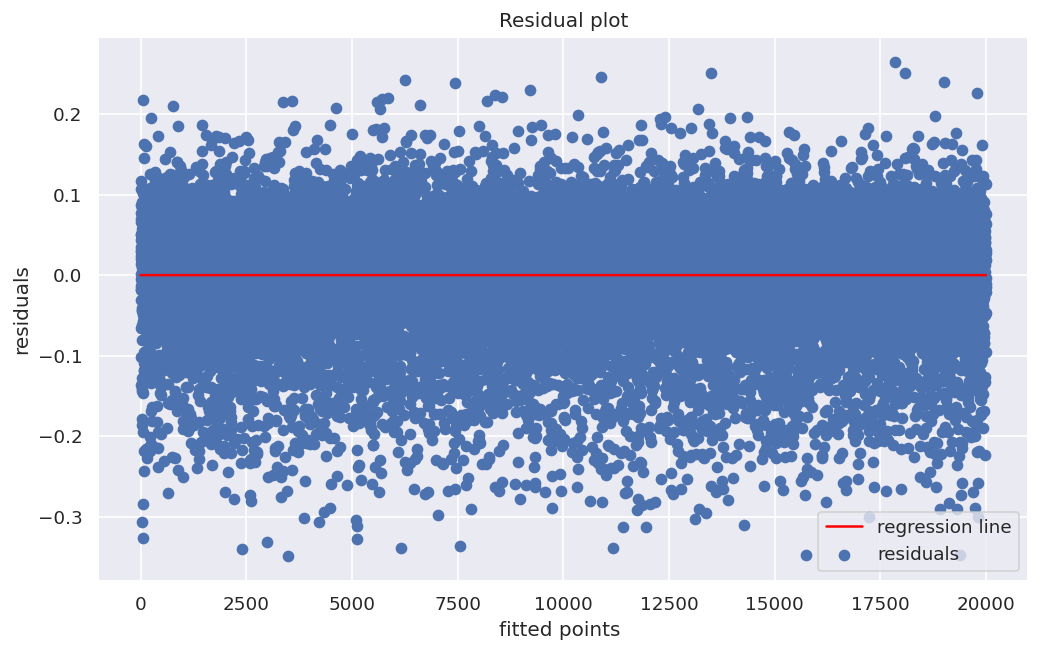

In [ ]:
#Heteroskedasticity
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

###Decision Tree

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.3s
[CV] max_depth=4, min_samples_leaf=10, min

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split

In [ ]:
dt_grid.best_score_

0.6086303710771939

In [ ]:
dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dt_optimal_model =dt_grid.best_estimator_

In [ ]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

In [ ]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

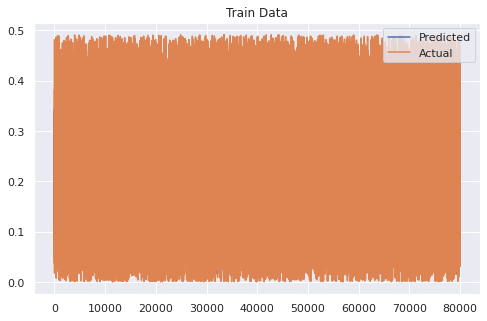

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_dt_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.003933693284929908
Train RMSE : 0.0627191620234989
Train R2 : 0.6437001193563989
Train Adjusted R2 :  0.6436154769741506


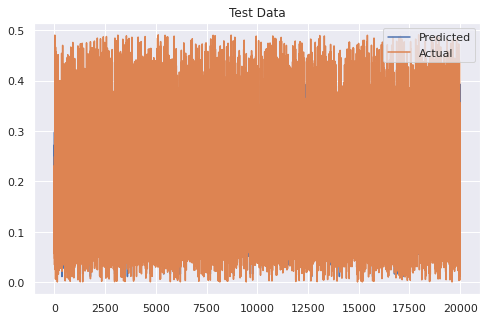

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_dt_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.004235598377226901
Test RMSE : 0.06508147491588448
Test R2 : 0.609772634819681
Test Adjusted R2 :  0.6094015477356758


In [ ]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
dt_optimal_model.feature_importances_

array([9.38968142e-04, 4.43967868e-05, 9.12159374e-03, 4.52624602e-03,
       1.10952278e-02, 5.23422795e-02, 7.95299356e-01, 1.13750226e-03,
       9.12148562e-02, 1.38090212e-03, 0.00000000e+00, 0.00000000e+00,
       1.15545919e-03, 1.85697790e-03, 1.27165769e-02, 1.60198960e-02,
       7.31804693e-04, 1.33113813e-04, 2.84843170e-04])

In [ ]:
importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
importance_df

,Feature,Feature Importance
0,vendor_id,0.00
1,passenger_count,0.00
2,pickup_longitude,0.01
3,pickup_latitude,0.00
4,dropoff_longitude,0.01
5,dropoff_latitude,0.05
6,distance,0.80
7,month,0.00
8,hour,0.09
9,minute,0.00


In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
6,distance,0.80
8,hour,0.09
5,dropoff_latitude,0.05
15,Day_Sunday,0.02
2,pickup_longitude,0.01
4,dropoff_longitude,0.01
14,Day_Saturday,0.01
0,vendor_id,0.00
12,Day_Friday,0.00
17,Day_Tuesday,0.00


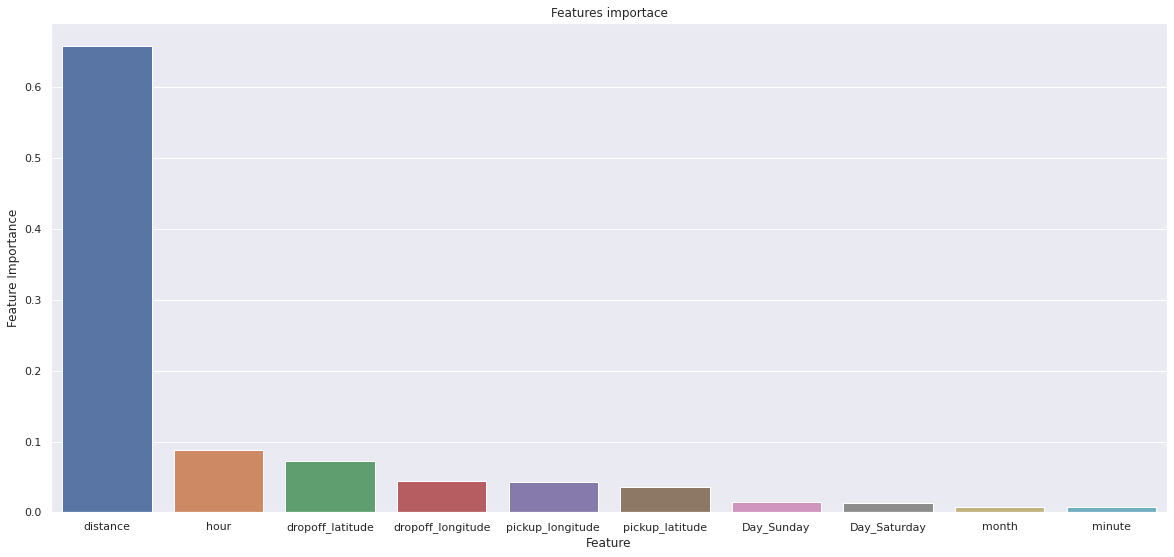

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

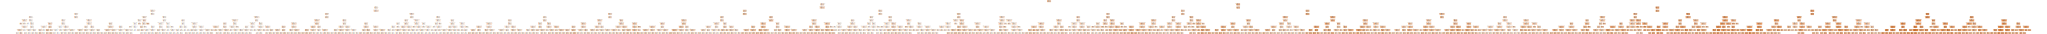

In [ ]:
graph = Source(tree.export_graphviz(dt_optimal_model, out_file=None,feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

###lasso

In [ ]:
#lasso regression
from sklearn.model_selection import GridSearchCV
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
lasso_regressor.score(X_train, y_train)

0.4977738411445112

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  0.4974340979109432


In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_lasso_train = lasso_regressor.predict(X_train)

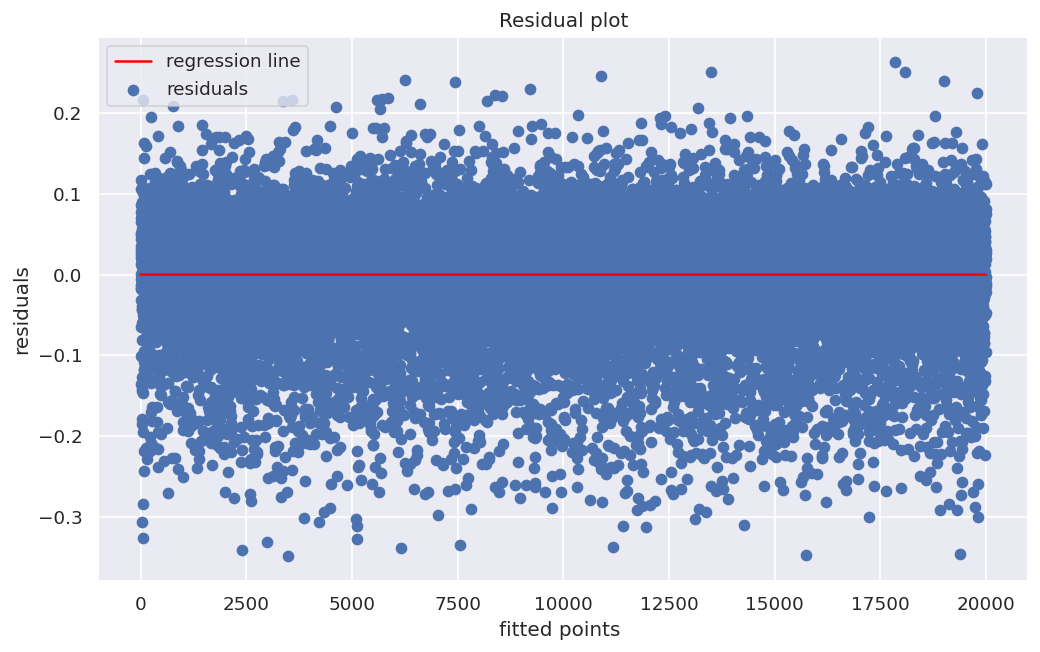

In [ ]:
#Heteroskedasticity
residuals=y_pred_lasso-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

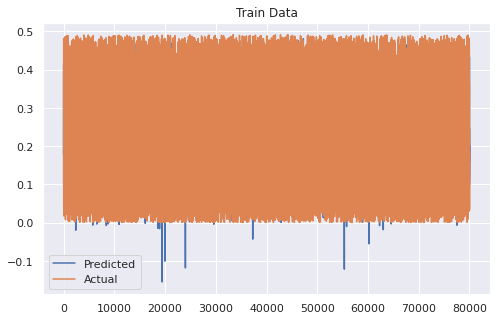

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_lasso_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.0055447778007597205
Train RMSE : 0.07446326477371054
Train R2 : 0.4977738411445112
Train Adjusted R2 :  0.4976545326046481


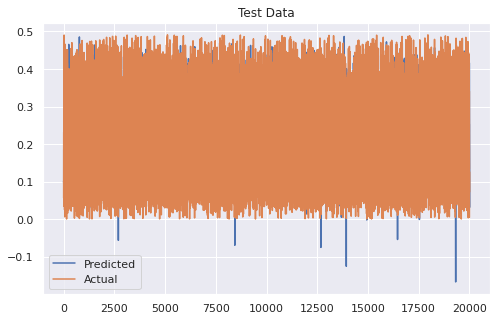

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_lasso)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_lasso)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.005470898041080057
Test RMSE : 0.07396551927134735
Test R2 : 0.4959639848718186
Test Adjusted R2 :  0.49548467134391894


###ridge

In [ ]:
from sklearn.linear_model import Ridge
### Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
ridge_regressor.score(X_train, y_train)

0.4977736866009548

In [ ]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 60}

Using  {'alpha': 60}  the negative mean squared error is:  0.4974340979109432


In [ ]:
y_pred_ridge_test = ridge_regressor.predict(X_test)
y_pred_ridge_train=ridge_regressor.predict(X_train)

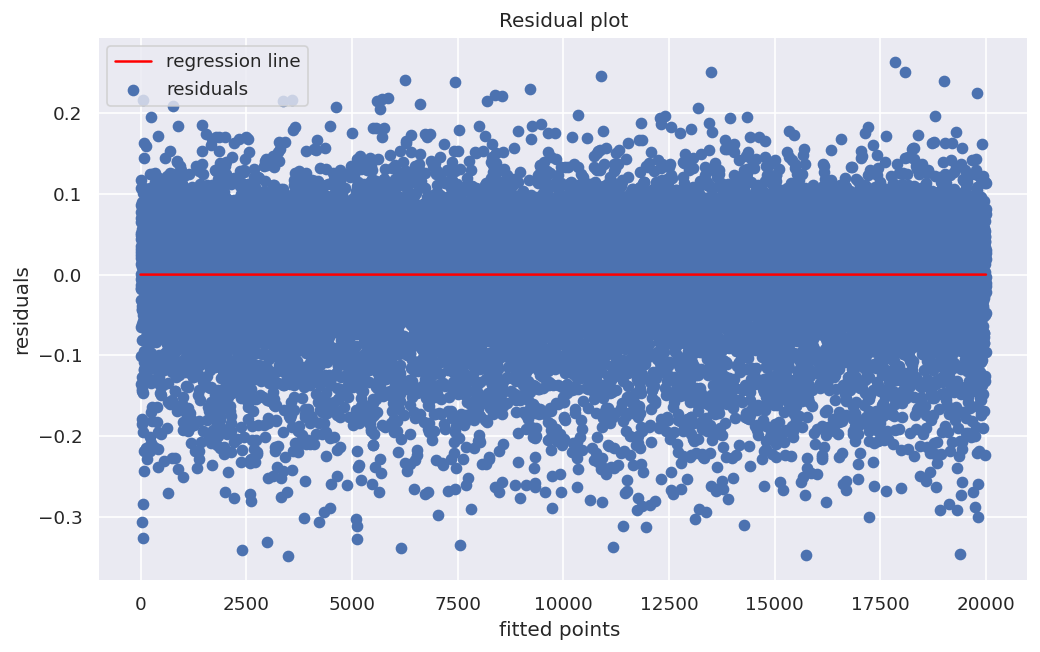

In [ ]:
#Heteroskedasticity
residuals=y_pred_ridge_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()


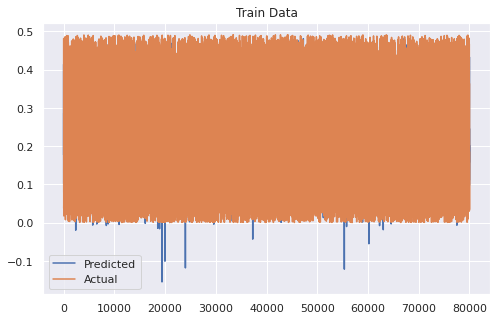

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_ridge_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.005544779506982436
Train RMSE : 0.07446327623051806
Train R2 : 0.4977736866009548
Train Adjusted R2 :  0.4976543780243784


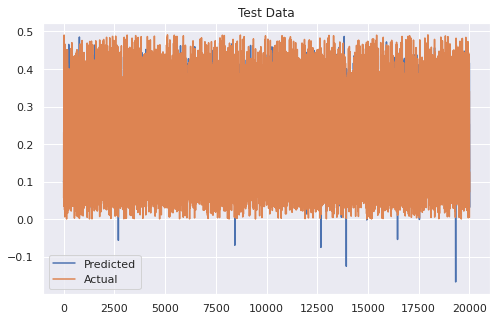

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Test Data")
plt.plot(y_pred_ridge_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.005470874963983531
Test RMSE : 0.07396536327216632
Test R2 : 0.4959661109739113
Test Adjusted R2 :  0.4954867994678305


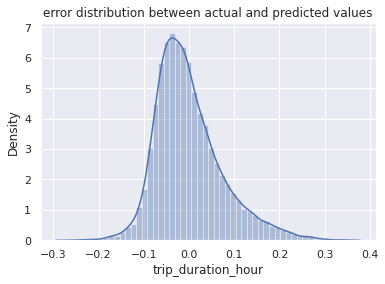

In [ ]:
sns.distplot(y_test - y_pred_ridge_test ).set_title("error distribution between actual and predicted values")
plt.show()

###xgboost

In [ ]:
# Number of trees
n_estimators = [50,100,120]

# Maximum depth of trees
max_depth = [5,7,9]
min_samples_split = [40,50]
#learning_rate=[0.1,0.3,0.5]

# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_split':min_samples_split
              }

In [ ]:
# Create an instance of the  XGBRegressor
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,param_grid = param_xgb,cv = 3, verbose=2,scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[09:58:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.8s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[09:58:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.6s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[09:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.7s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[09:58:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   7.4s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[09:58:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   7.3s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[09:58:55] WARNING: /workspace/src/objective/

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimators': [50, 100, 1

In [ ]:
xgb_grid.best_score_

0.7026952351641338

In [ ]:
xgb_grid.best_params_

{'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 120}

In [ ]:
xgb_optimal_model =xgb_grid.best_estimator_

In [ ]:
y_pred_xgb_test=xgb_optimal_model.predict(X_test)
y_pred_xgb_train=xgb_optimal_model.predict(X_train)

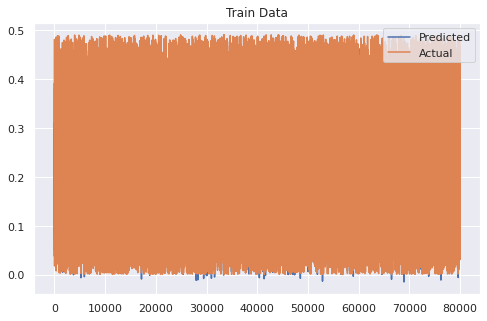

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_xgb_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.001963513255289278
Train RMSE : 0.044311547651704496
Train R2 : 0.8221519859766687
Train Adjusted R2 :  0.8221097365109717


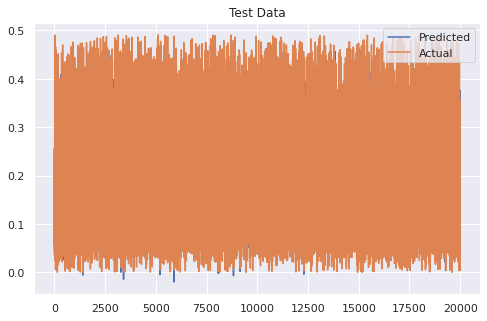

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_xgb_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.003144094792953189
Test RMSE : 0.056072228357299914
Test R2 : 0.7103332946938756
Test Adjusted R2 :  0.710057835865006


In [ ]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
xgb_optimal_model.feature_importances_

array([0.00625629, 0.00633789, 0.01918391, 0.01993586, 0.02414751,
       0.04146331, 0.43513972, 0.01926788, 0.08249865, 0.01088677,
       0.01079909, 0.        , 0.01828299, 0.05281273, 0.07541084,
       0.10604851, 0.02390587, 0.02580334, 0.02181888], dtype=float32)

In [ ]:
importances = xgb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)

In [ ]:
importance_df

,Feature,Feature Importance
0,vendor_id,0.01
1,passenger_count,0.01
2,pickup_longitude,0.02
3,pickup_latitude,0.02
4,dropoff_longitude,0.02
5,dropoff_latitude,0.04
6,distance,0.44
7,month,0.02
8,hour,0.08
9,minute,0.01


In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)

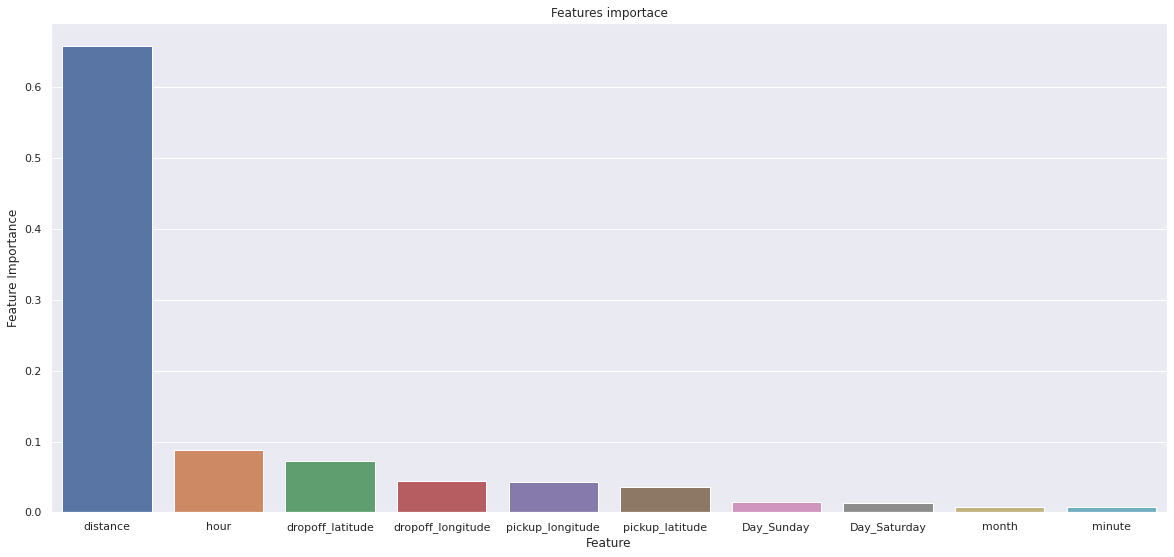

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

In [ ]:
#applying gradient boosting
# Number of trees
n_estimators = [100,120]

# Maximum depth of trees
max_depth = [5,8,10]

# Minimum number of samples required to split a node
min_samples_split = [50,80]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]


# HYperparameter Grid
param_gb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

###GradientBoostingRegressor

In [ ]:
# Create an instance of the  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model=GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_gb,
                       cv = 3, verbose=2, scoring='r2')

gb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  24.7s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  24.6s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  24.6s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  29.5s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  29.5s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  29.6s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=80, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=80, n_estimators=100, total=  25.4s
[CV] max_depth=5, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 48.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...ge=None,
                    

In [ ]:
gb_grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 120}

In [ ]:
gb_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=50,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
gb_optimal_model = gb_grid.best_estimator_

In [ ]:
y_preds_gb = gb_optimal_model.predict(X_test)
y_pred_gb_train=gb_optimal_model.predict(X_train)

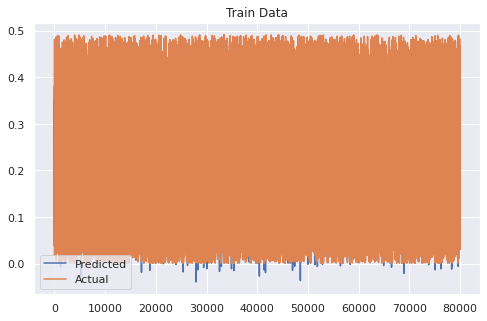

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_gb_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_train, y_pred_gb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_gb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_gb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.002269044615308303
Train RMSE : 0.04763448976643187
Train R2 : 0.79447804720653
Train Adjusted R2 :  0.7944292235368242


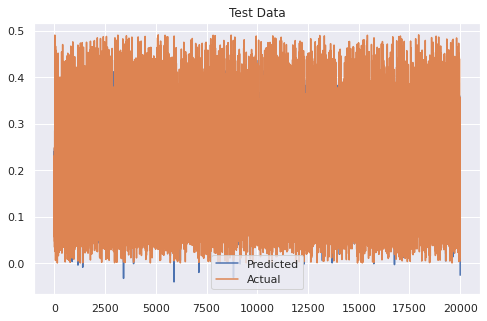

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_preds_gb)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(y_test, y_preds_gb)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_preds_gb)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_preds_gb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.0031349293703607987
Test RMSE : 0.055990439990776984
Test R2 : 0.7111777087271378
Test Adjusted R2 :  0.7109030528945961


In [ ]:
gb_optimal_model.feature_importances_

array([1.88338747e-03, 7.24831229e-04, 4.24326591e-02, 3.53574425e-02,
       4.40786158e-02, 7.30174027e-02, 6.57867995e-01, 8.02364166e-03,
       8.87355808e-02, 7.59078159e-03, 7.70325254e-06, 0.00000000e+00,
       2.16537994e-03, 4.14327240e-03, 1.30789054e-02, 1.52072865e-02,
       2.01223216e-03, 1.78397752e-03, 1.88890481e-03])

In [ ]:
importances = gb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [ ]:
importance_df['Feature Importance'] = importance_df['Feature Importance']
importance_df

,Feature,Feature Importance
0,vendor_id,0.001883
1,passenger_count,0.000725
2,pickup_longitude,0.042433
3,pickup_latitude,0.035357
4,dropoff_longitude,0.044079
5,dropoff_latitude,0.073017
6,distance,0.657868
7,month,0.008024
8,hour,0.088736
9,minute,0.007591


In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
6,distance,0.657868
8,hour,0.088736
5,dropoff_latitude,0.073017
4,dropoff_longitude,0.044079
2,pickup_longitude,0.042433
3,pickup_latitude,0.035357
15,Day_Sunday,0.015207
14,Day_Saturday,0.013079
7,month,0.008024
9,minute,0.007591


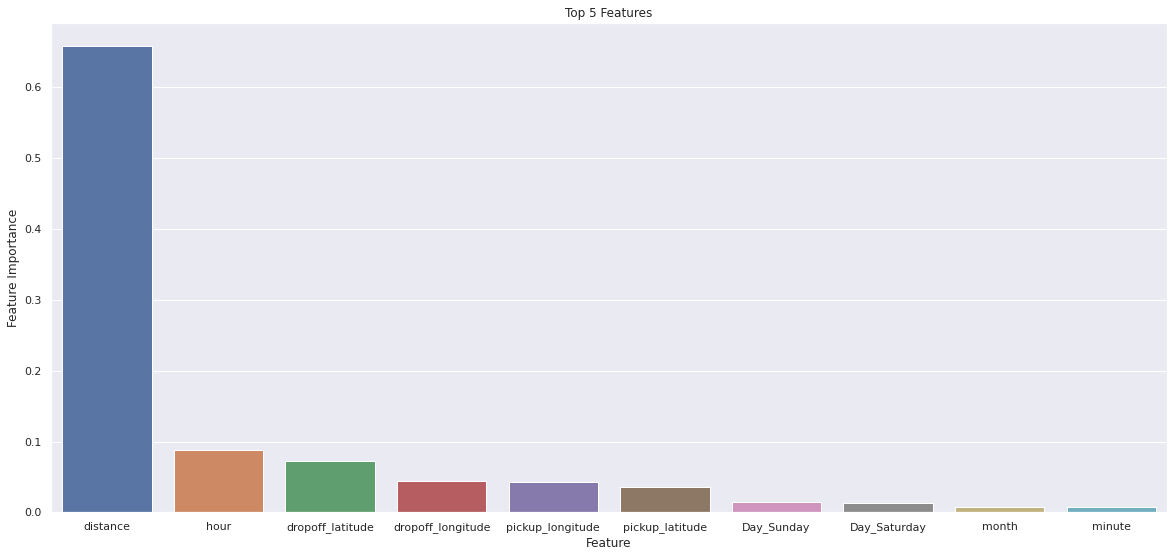

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Top 5 Features')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

###Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()

In [ ]:
params = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5,10,15,20,25]}

In [ ]:
# Setting up RandomizedSearchcv

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
# Starting the model and carrying out with no.of folds = 3+

rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
# Seeing the best estimator

rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Seeing the best parameters for the model

rf_random.best_params_

{'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 25}

In [ ]:
# Creating instance of the best model

best_rfmodel = rf_random.best_estimator_

In [ ]:
# Training the best model

best_rfmodel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Capturing the predictions of our model on training dataset

train_pred = best_rfmodel.predict(X_train)

In [ ]:
# Capturing the predictions of our model on testing dataset

test_pred = best_rfmodel.predict(X_test)

In [ ]:
train_pred

array([0.35163664, 0.35983112, 0.25342158, ..., 0.03651996, 0.07938896,
       0.18632532])

In [ ]:
test_pred

array([0.0932689 , 0.12558105, 0.09277693, ..., 0.08215806, 0.15837305,
       0.01991809])

In [ ]:
MSE  = mean_squared_error(y_train, train_pred)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, train_pred)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (train_pred)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.0013872091547226767
Train RMSE : 0.03724525680838671
Train R2 : 0.8743515519756118
Train Adjusted R2 :  0.8743217030069639


In [ ]:
MSE  = mean_squared_error(y_test, test_pred)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, test_pred)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (test_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.0035268063033476785
Test RMSE : 0.059386920305296846
Test R2 : 0.6750739308390807
Test Adjusted R2 :  0.6747649420846235


In [ ]:
# Results of training and testing datasets by our model, 
# through this we could say that our model is better than baseline model

print(mean_squared_error(y_train,train_pred,squared=False))
print(mean_squared_error(y_test,test_pred,squared=False))
print("r2_score (test): {:.2f}".format(r2_score(y_test,test_pred)))
print("r2_score (train): {:.2f}".format(r2_score(y_train,train_pred)))

0.03724525680838671
0.059386920305296846
r2_score (test): 0.68
r2_score (train): 0.87


In [ ]:
#Summary for Train Data
from prettytable import PrettyTable
train = PrettyTable(['SL NO',"MODEL_NAME", "Train MSE", "Train RMSE",'Train R^2','Train Adjusted R^2'])
train.add_row(['1','Linear Regression','0.005546665930139359','0.07447594195536811','0.4976028211325536811','0.4974834719652863'])
train.add_row(['2','Lasso Regression','0.0055447778007597205','0.07446326477371054','0.4977738411445112','0.4976545326046481'])
train.add_row(['3','Ridge Regression ','0.005544779506982436','0.07446327623051806','0.4977736866009548','0.4976543780243784'])
train.add_row(['4','DecisionTree Regressor','0.003933693284929908','0.0627191620234989','0.6437001193563989','0.6436154769741506'])
train.add_row(['5','XGBRegressor','0.001963513255289278','0.044311547651704496','0.8221519859766687','0.8221097365109717'])
train.add_row(['6','GradientBoosting','0.002269044615308303','0.04763448976643187','0.79447804720653','0.7944292235368242'])
print(train)

+-------+------------------------+-----------------------+----------------------+-----------------------+--------------------+
| SL NO |       MODEL_NAME       |       Train MSE       |      Train RMSE      |       Train R^2       | Train Adjusted R^2 |
+-------+------------------------+-----------------------+----------------------+-----------------------+--------------------+
|   1   |   Linear Regression    |  0.005546665930139359 | 0.07447594195536811  | 0.4976028211325536811 | 0.4974834719652863 |
|   2   |    Lasso Regression    | 0.0055447778007597205 | 0.07446326477371054  |   0.4977738411445112  | 0.4976545326046481 |
|   3   |   Ridge Regression     |  0.005544779506982436 | 0.07446327623051806  |   0.4977736866009548  | 0.4976543780243784 |
|   4   | DecisionTree Regressor |  0.003933693284929908 |  0.0627191620234989  |   0.6437001193563989  | 0.6436154769741506 |
|   5   |      XGBRegressor      |  0.001963513255289278 | 0.044311547651704496 |   0.8221519859766687  | 0.822

In [ ]:
#summary for test Data
from prettytable import PrettyTable
test = PrettyTable(['SL NO',"MODEL_NAME", "Test MSE", "Test RMSE",'Test R^2','Test Adjusted R^2'])
test.add_row(['1','Linear Regression','0.005474782168878371',' 0.07399177095379168','0.4956061386310351','0.4951264848089125'])
test.add_row(['2','Lasso Regression','0.005470898041080057','0.07396551927134735','0.4959639848718186','0.49548467134391894'])
test.add_row(['3','Ridge Regression ','0.005470874963983531','0.07396536327216632','0.4959661109739113','0.4954867994678305'])
test.add_row(['4','DecisionTree Regressor','0.004235598377226902','0.0650814749158845','0.609772634819681',' 0.6094015477356758'])
test.add_row(['5','XGBRegressor','0.003144094792953189','0.05607228357299914','0.7103332946938756','0.710057835865006'])
train.add_row(['6','GradientBoosting','0.003134964933707763','0.05599075757397611','0.71117443226182','0.7108997733135205'])
print(test)

+-------+------------------------+----------------------+----------------------+--------------------+---------------------+
| SL NO |       MODEL_NAME       |       Test MSE       |      Test RMSE       |      Test R^2      |  Test Adjusted R^2  |
+-------+------------------------+----------------------+----------------------+--------------------+---------------------+
|   1   |   Linear Regression    | 0.005474782168878371 |  0.07399177095379168 | 0.4956061386310351 |  0.4951264848089125 |
|   2   |    Lasso Regression    | 0.005470898041080057 | 0.07396551927134735  | 0.4959639848718186 | 0.49548467134391894 |
|   3   |   Ridge Regression     | 0.005470874963983531 | 0.07396536327216632  | 0.4959661109739113 |  0.4954867994678305 |
|   4   | DecisionTree Regressor | 0.004235598377226902 |  0.0650814749158845  | 0.609772634819681  |  0.6094015477356758 |
|   5   |      XGBRegressor      | 0.003144094792953189 | 0.05607228357299914  | 0.7103332946938756 |  0.710057835865006  |
+-------